<a href="https://colab.research.google.com/github/hayannn/AIFFEL_STUDY/blob/main/%EC%BA%90%EA%B8%80_%EC%9E%90%EC%A0%84%EA%B1%B0%EB%8C%80%EC%97%AC%EC%88%98%EC%9A%94%EC%98%88%EC%B8%A1(Bike_Sharing_Demand).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bike Sharing Demand
- [Bike Sharing Demand](https://www.kaggle.com/c/bike-sharing-demand/overview)

## 0. 캐글 데이터 불러오기

In [ ]:
from google.colab import files
files.upload()

In [ ]:
ls -1ha kaggle.json

kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c bike-sharing-demand

  0% 0.00/189k [00:00<?, ?B/s]
100% 189k/189k [00:00<00:00, 69.5MB/s]


In [ ]:
!ls

bike-sharing-demand.zip  kaggle.json  sample_data


In [ ]:
!unzip -qq '/content/bike-sharing-demand.zip' -d '/content/'

In [ ]:
!ls

bike-sharing-demand.zip  kaggle.json  sample_data  sampleSubmission.csv  test.csv  train.csv


- 파일명 변경

In [ ]:
import os

# 원본 파일
o_file = "/content/train.csv"

# 새 파일
n_file = "/content/bike_train.csv"

os.rename(o_file, n_file)

In [ ]:
!ls

bike-sharing-demand.zip  bike_train.csv  kaggle.json  sample_data  sampleSubmission.csv  test.csv


## 1. 데이터 기본 정보 파악
- 2011년 1월 ~ 2012년 12월 날짜/시간, 기온, 습도, 풍속 등의 정보를 기반으로 1시간 간격 동안의 자전거 대여 횟수 기재
- **결정값 : count(대여 횟수)**
- 컬럼 정보
  - `datetime` - hourly date + timestamp  
  - `season` -  1 = spring, 2 = summer, 3 = fall, 4 = winter
  - `holiday`
    - 1=토, 일요일의 주말을 제외한 국경일 등의 휴일
    - 0=휴일이 아닌 날
  - `workingday`
    - 1=토, 일요일의 주말 및 휴일이 아닌 주중, 0=주말 및 휴일
  - `weather`
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy(맑음, 약간 구름 낀 흐림)
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist(안개, 안개 + 흐림)
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds(가벼운 눈, 가벼운 비 + 천둥)
   - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog(심한 눈/비, 천둥/번개)
  - `temp` - 섭씨온도
  - `atemp` - 섭씨 체감 온도
  - `humidity` - 상대 습도
  - `windspeed` - 풍속
  - `casual` - 사전에 등록되지 않은 사용자가 대여한 횟수
  - `registered` - 사전에 등록된 사용자가 대여한 횟수
  - `count` - 대여 횟수

## 2. 데이터 클렌징 및 가공과 데이터 시각화
- 대여 횟수(count) 예측
  - 10886개의 레코드와 12개의 컬럼으로 구성

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

bike_df = pd.read_csv('/content/bike_train.csv')
print(bike_df.shape)
bike_df.head(3)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


<br>
<br>

- 데이터 타입 확인
  - 결측치 없음
  - datetime 컬럼만 object형

In [ ]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


<br>
<br>

- datetime 가공
  - 년, 월, 일, 시간의 4개 속성으로 분리
  - 판다스의 apply(pd.to_datetime) 메서드 사용

In [ ]:
# datetime 타입으로 변경
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 "년, 월, 일, 시간" 추출
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x: x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


<br>
<br>

- 모든 컬럼의 상관행렬 계산해보기

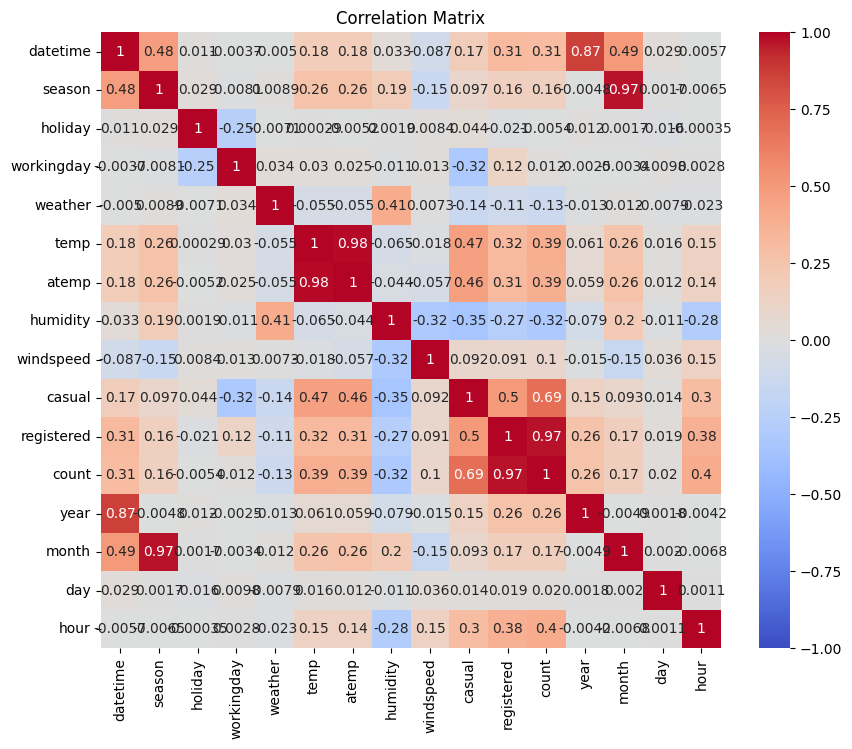

In [ ]:
correlation_matrix = bike_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

- 두 컬럼의 상관도 수치로 더 명확히 파악

In [ ]:
correlation = bike_df['casual'].corr(bike_df['registered'])
print(f"Correlation between 'casual' and 'registered': {correlation}")

Correlation between 'casual' and 'registered': 0.4972496850870083


<br>
<br>

- year, month, day, hour 컬럼 추가됨 -> datetime 컬럼 삭제
- 불필요한 컬럼 삭제: casual, registered -> 이 둘을 더한 것이 count가 되기 때문에, 이 둘이 따로 필요하지 않다고 판단
  - 또한 이 두 컬럼이 상관도가 높아 예측을 저해할 우려가 있음!

In [ ]:
drop_columns = ['datetime','casual','registered']
bike_df.drop(drop_columns, axis=1,inplace=True)

<br>
<br>

- Target 값인 count(대여 횟수)가 어떤 분포를 보이는지 시각화
  - 컬럼별 값에 따른 count 합을 표현

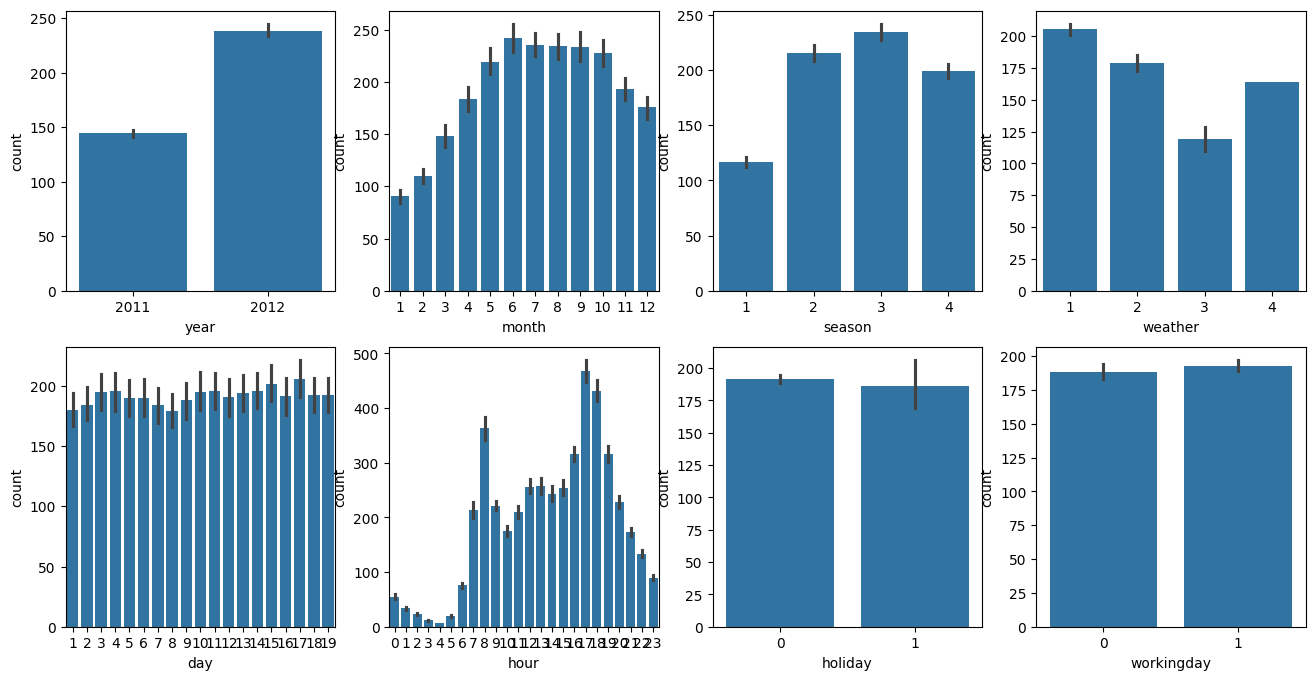

In [ ]:
fig, axs = plt.subplots(figsize=(16, 8), ncols=4, nrows=2)
cat_features = ['year', 'month','season','weather','day', 'hour', 'holiday','workingday']

# cat_features에 있는 모든 칼럼별로 개별 칼럼값에 따른 count의 합을 barplot으로 시각화
for i, feature in enumerate(cat_features):
    row = int(i/4)
    col = i%4

    # 시본의 barplot을 이용해 칼럼값에 따른 count의 합 보여주기
    sns.barplot(x=feature, y='count', data=bike_df, ax=axs[row][col])

- year(연도)별 count
  - 2012년 > 2011년 : 시간이 지날수록 자전거 대여 횟수가 지속적으로 증가한 결과
- month별 count
  - 1,2,3월 ⬇️
  - 6,7,8,9월 ⬆️
- season별 count
  - 봄, 겨울 ⬇️(1, 4)
  - 여름, 가을 ⬆️(2, 3)
- weather별 count
  - 눈 또는 비가 있는 경우 ⬇️(3, 4)
  - 맑거나 약간 안개가 있는 경우 ⬆️(2)
- hour별 count
  - 오전 출근 시간(8), 오후 퇴근 시간(17, 18) ⬆️
- day별 count
  - 차이가 크지 않음
- holiday별 count, workingday별 count
  - 주중일 경우(holiday 0, workingday 1)가 상대적으로 ⬆️

<br>
<br>

- 캐글에서의 지표
  - "Submissions are evaluated one the Root Mean Squared Logarithmic Error (RMSLE)"
  - RMSLE는 바로 계산하는 라이브러리가 없으므로 함수 만들기!
- 또한, RMSLE, RMSE, MAE를 모두 계산할 수 있도록 추가

> 참고: loglp()로 변환된 값 -> 넘파이의 expm1() 함수로 쉽게 원래 스케일로 복원할 수 있음!

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log값 변환 시 NaN 등의 이슈 -> log()가 아닌 log1p()를 이용하여 RMSLE 계산
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷런의 mean_square_error()를 이용하여 RMSE 계산
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

# MSE, RMSE, RMSLE를 모두 계산
def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    # MAE 는 scikit learn의 mean_absolute_error() 로 계산
    mae_val = mean_absolute_error(y,pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

## 3. 로그 변환, 피처 인코딩, 모델 학습/예측/평가
### 3-1. 데이터 분포 확인 및 인코딩
- 결과값이 정규 분포로 되어있는지 확인
- 카테고리형 회귀 모델 -> 원-핫 인코딩으로 피처 인코딩

<br>
<br>

#### 가공 이전
- 우선, 사이킷런의 LinearRegression 객체를 이용해 회귀 예측부터 해보기
  - 실제 Target 데이터 값인 count(대여 횟수)를 감안하면 -> 옟ㄱ 오류 측면에서 비교적 큰 값!

In [ ]:
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.linear_model import LinearRegression , Ridge , Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'],axis=1,inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test ,pred)

RMSLE: 1.165, RMSE: 140.900, MAE: 105.924


<br>
<br>

- 실제값과 예측값이 어느 정도 차이가 나는지 DataFrame 컬럼으로 만들어 오류값이 가장 큰 순으로 5개만 확인
  - diff를 보면 알 수 있듯, 오류값은 실제값을 감안하면 에측 오류가 큰 편
- 회귀에서 이렇게 큰 오류를 보게 되면 해야 할 일
  - Target 값 분포가 왜곡된 형태를 이루는지 확인!
  - Target 값 분포는 정규 분포 형태가 가장 좋음

In [ ]:
def get_top_error_data(y_test, pred, n_tops = 5):
    # DataFrame에 컬럼들로 실제 대여횟수(count)와 예측값을 서로 비교할 수 있도록 생성
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count']= np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])

    # 예측값과 실제값이 가장 큰 데이터순으로 출력
    print(result_df.sort_values('diff', ascending=False)[:n_tops])

get_top_error_data(y_test,pred,n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


<br>
<br>

#### 로그 변환 진행
- count 컬럼이 정규 분포를 이루는지 확인
  - 정규 분포가 아닌 0~200 사이에 왜곡되어 있음을 확인 가능
  - log를 적용해서 변환하면 정규 분포로 변환 가능

<Axes: >

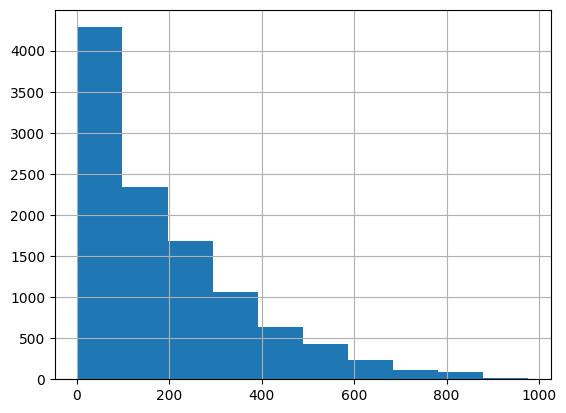

In [ ]:
y_target.hist()

- log1p()로 변환
  - 원하는 정도의 정규 분포는 아님 -> 하지만, 변환 전보다는 왜곡 정도가 많이 향상됨!

<Axes: >

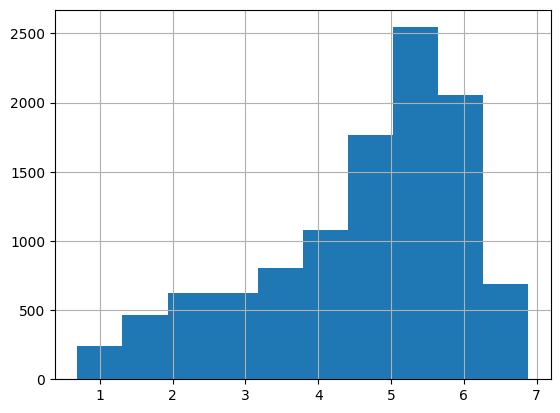

In [ ]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

<br>
<br>

- Target 값의 로그 변환 후 재학습 버전
  - RMSLE 오류는 줄었으나, RMSE는 오히려 증가

In [ ]:
# 이전 수치 : RMSLE: 1.165, RMSE: 140.900, MAE: 105.924
# 타깃 칼럼인 count 값을 log1p로 로그 변환
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영하여 학습/테스트 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 셋의 Target값은 Log 변환되었으므로 다시 expm1를 이용하여 원래 scale로 변환
y_test_exp = np.expm1(y_test)

# 예측값 역시 Log 변환된 타깃 기반으로 학습되어 예측되었으므로 다시 exmpl으로 scale변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp ,pred_exp)

RMSLE: 1.017, RMSE: 162.594, MAE: 109.286


<br>
<br>

#### 개별 피쳐들의 인코딩 적용(원-핫 인코딩)
- 각 피처의 회귀 계수 시각화

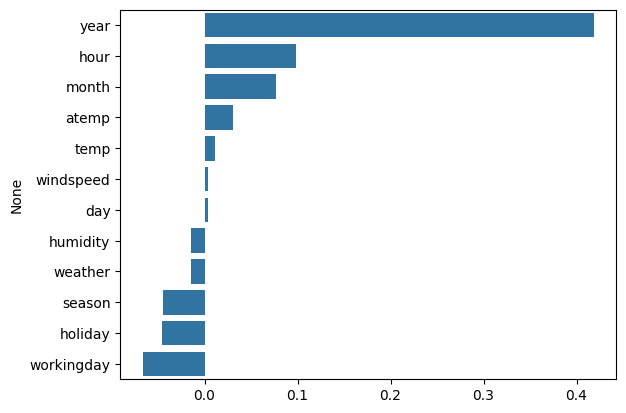

In [ ]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)
plt.savefig('log_transform.tif', format='tif', dpi=300, bbox_inches='tight')

- year, hour, month, season, holiday, workingday
  - 회귀 계수 영향도가 상대적으로 높은 편
    - year : 단순 연도 표현이기 때문에 2012라는 값이 2011보다 큰 값으로 인식되면 ❌
  - 해당 컬럼들은 숫자값으로 표현되었으나 **숫자형 카테고리** 피쳐!

> 원-핫 인코딩으로 숫자형 값 영향을 줄어야 함
- 'year', 'month','day', 'hour', 'holiday', 'workingday','season','weather'

In [ ]:
# 'year', month', 'day', hour'등의 피처들을 One Hot Encoding
X_features_ohe = pd.get_dummies(X_features, columns=['year', 'month','day', 'hour', 'holiday', 'workingday','season','weather'])

<br>
<br>

#### 사이킷런의 선형 회귀 모델 적용
- LinearRegression
- Ridge
- Lasso

In [ ]:
# 원-핫 인코딩이 적용된 feature 데이터 세트 기반으로 학습/예측 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, test_size=0.3, random_state=0)

# 모델과 학습/테스트 데이터셋을 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)

# model별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model,X_train, X_test, y_train, y_test,is_expm1=True)

### LinearRegression ###
RMSLE: 0.590, RMSE: 97.688, MAE: 63.382
### Ridge ###
RMSLE: 0.590, RMSE: 98.529, MAE: 63.893
### Lasso ###
RMSLE: 0.635, RMSE: 113.219, MAE: 72.803


<br>
<br>

#### 원-핫 인코딩된 데이터 세트에서 회귀 계수가 높은 피처를 다시 시각화
- 피쳐가 늘었으므로 회귀 계수 상위 20개 피쳐 추출

<Axes: ylabel='None'>

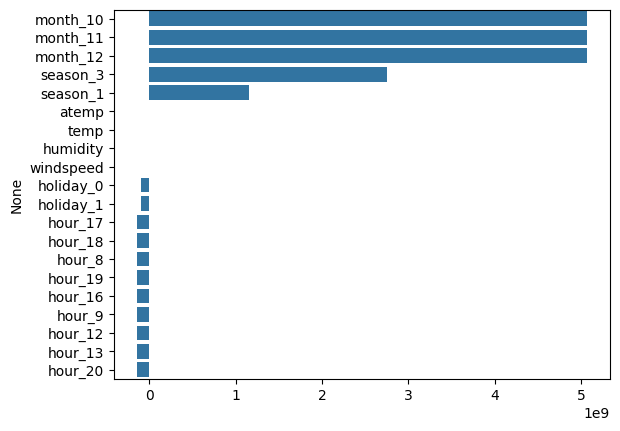

In [ ]:
coef = pd.Series(lr_reg.coef_ , index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values , y=coef_sort.index)

> 결론 : 선형 회귀의 경우 중요 카테고리성 피쳐들을 원-핫 인코딩으로 변환하는 것은 성능에 중요한 영향을 미칠 수 있음!

<br>
<br>

#### 회귀 트리를 이용해 회귀 예측 수행
- 앞서 적용한 Target 값의 로그 변환된 값과 원-핫 인코딩된 피쳐 데이터 세트를 그대로 이용
- 랜덤 포레스트, GBM, XGBoost, LightGBM을 순차적으로 성능 평가

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import warnings

warnings.filterwarnings('ignore')

# 랜덤 포레스트, GBM, XGBoost, LightGBM model별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500, verbose=-1) # verbose=-1로 warning 출력 제거(사이킷런 버전 업데이트로 인해 warning이 자동 출려되는데 너무 길어서 수치르 보기 어려우니 ignore 처리)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    # XGBoost: DataFrame이 입력될 경우 버전에 따라 오류 발생(ndarray로 변환)
    get_model_predict(model,X_train.values, X_test.values, y_train.values, y_test.values,is_expm1=True)

### RandomForestRegressor ###
RMSLE: 0.354, RMSE: 50.302, MAE: 31.135
### GradientBoostingRegressor ###
RMSLE: 0.330, RMSE: 53.339, MAE: 32.741
### XGBRegressor ###
RMSLE: 0.339, RMSE: 51.475, MAE: 31.357
### LGBMRegressor ###
RMSLE: 0.319, RMSE: 47.215, MAE: 29.029


# 회고
이번 데이터의 경우, 컬럼 수가 적당한 편이라고 느껴져서 그 사이의 관계에 대해서 직관적으로 이해하기 쉬웠음.
또한, 데이터들도 날씨에 따라 명확하게 수치가 크고 작음이 보여 컬럼 간의 관계를 깊게 고민하지 않아도 되는 점이 좋았음.
<br>
<br>
다만, casual과 registered 사이의 상관도가 크고 이 둘을 더한 지표가 count와 동일하기 때문에 컬럼을 삭제한다고 표현되어 있던 부분에 대해서는 고민이 생겼음.
상관도를 낮춰야 모델에서의 예측 성능이 올라간다는 것은 명백한 사실이기 때문에 납득할 수 있었으나, 컬럼 삭제 외의 방법으로도 상관도를 충분히 낮출 수 있지 않았을까 하는 생각임.<br>
개인적으로는 casual이 사전에 등록하지 않는 사용자 수이고, registered는 사전 등록한 사용자 수를 보여주는 지표인데 이게 과연 자전거 대여 수요 예측에 불필요한게 맞을까?라는 의견.
<br>
<br>
수치적 측면을 제외하고 이론적으로 생각을 해보면..
<br>
사전 등록을 하고 이용하는 사람들과 사전 등록을 하지 않고 이용하는 사람들의 수요를 분리해서 파악하고, 그 수요가 높은 쪽으로 모델을 학습시켜야 조금 더 이 프로젝트의 목표에 부합하지 않을까하는 고민이 들었음.
<br>
<br>

따라서 내일 있을 캐글 모의 대회에서는 컬럼 삭제 측면에 있어 삭제가 불가피한 상황이 아니라면 컬럼에 대한 미삭제 근거를 명확히 한 다음 컬럼을 처리할 것임!